In [ ]:
!sudo apt install tesseract-ocr libtesseract-dev
!sudo apt-get install tesseract-ocr-chi-sim
!pip install pytesseract opencv-python-headless
!pip install paddleocr
!pip install paddlepaddle
!pip install Levenshtein

In [2]:
import cv2
import re
import pytesseract
import numpy as np
import os
import random
import time
import Levenshtein
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
from PIL import Image
from pytesseract import Output
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 创建一个专门用于侵蚀黑色值的函数 灰度-》二值化-》侵蚀
# Create a function dedicated to eroding black values Grayscale -> Binarization -> Erosion.
# 调整： 进行反转以侵蚀黑色
# Adjustment: Invert to erode black.
def erode_black(image, min_line_width=2, edge_width=6):
  # 判断，调整顺序时防止报错
  # Judgment to prevent reporting errors when adjusting the order
  if len(image.shape) == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    gray = image.copy()

  # 二值化，这里是需要侵蚀黑色的部分，反转一下
  # Binarization, here is the part that needs to erode the black, invert it.
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 创建水平和垂直的kernel
  # Create horizontal and vertical kernel.
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (min_line_width, 2))
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (min_line_width, 2))

  # 水平线和垂直线腐蚀 迭代一次
  # Horizontal and vertical line erosion. Iterate once.
  eroded_horizontal = cv2.erode(binary, horizontal_kernel, iterations=1)
  eroded_vertical = cv2.erode(binary, vertical_kernel, iterations=1)

  # 合并水平和垂直腐蚀
  # Combined horizontal and vertical corrosion.
  eroded = cv2.bitwise_or(eroded_horizontal, eroded_vertical)

  # 把图像反转回来
  # Invert the image back.
  result = cv2.bitwise_not(eroded)

  return result

# 整理所有的预处理，返回处理后的图片结果
# 调整：输入文件地址，减少占用
# Organize all the preprocessing and return the result of the processed image.
# Adjustment: input file address to reduce occupancy.
def pre_processing(path):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gaussian = cv2.GaussianBlur(gray, (7,7), 0)
  erode = erode_black(gaussian)
  median = cv2.medianBlur(erode, 3)
  return median

# 撰写一个根据需求返回文件的函数
# Write a function that returns files on demand.
def get_files(folder_path, percentage = 1):
  files = os.listdir(folder_path)
  if not files:
    print(f"文件夹 {folder_path} 中没有符合条件的文件")
    return []
  # 获取所有名字后进行占比的计算
  # Get all the names and then do the calculation of the percentage
  percentage = max(0, min(1, percentage))
  number = max(int(len(files)*percentage), 1)
  selected_files = random.sample(files, number)

  files_list = []
  for file in selected_files:
    t = os.path.join(folder_path, file)
    files_list.append(t)

  # 返回全路径,文件名字(比对标准) 还有数量
  # Returns the full path, the file name (to match the standard), and the number.
  return files_list, selected_files, len(selected_files)


# 编写函数处理ocr返回的俩个结果
# Write a function to handle the two results returned by ocr.
def text_and_possibility(result):
  try:
    text = result[0][0][1][0]
    possibility = result[0][0][1][1]
    return text,possibility
  except:
    return '',''

In [16]:
def calculate_cer(reference, hypothesis):
  # 如果有空的而另外一个不是空的则完全错误
  # If there is an empty one and the other one is not empty then it is a complete error.
  if not reference and not hypothesis:
      return 0.0
  if not reference or not hypothesis:
      return 1.0
  return Levenshtein.distance(reference, hypothesis)/len(reference)

def calculate_wer(reference, hypothesis):
  if not reference and not hypothesis:
      return 0.0
  if not reference or not hypothesis:
      return 1.0
  ref_words = reference.split()
  hyp_words = hypothesis.split()
  return Levenshtein.distance(ref_words, hyp_words)/len(ref_words)

# 接收预测值和正确答案，进行对比，评估正确性并返回
# Receives the predicted value and the correct answer, compares them, evaluates the correctness.
def evaluate(ground_truth, predictions):
  total_cer = 0
  total_wer = 0
  total_count = len(ground_truth)

  for truth, pred in zip(ground_truth, predictions):
    total_cer += calculate_cer(truth, pred)
    total_wer += calculate_wer(truth, pred)

  avg_cer = total_cer/total_count
  avg_wer = total_wer/total_count

  return {
      "Average CER": avg_cer,
      "Average WER": avg_wer
  }

In [29]:
# 该模块处理所有的数据
# This module handles all the data
folder_path = '/content/drive/MyDrive/Dataset/math_dataset'

files_paths, answer, num = get_files(folder_path, 0.1)

# 创建两个列表分别存储识别的字符和概率
# Create two lists to store recognized characters and probabilities respectively.
predictions = []
ocr_possibility = []
ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, det=True, rec=True)

# 开始遍历, 顺便计时
# start traversing and record the time of duration.
start = time.perf_counter()
for files_path in files_paths:
  img = pre_processing(files_path)
  result = ocr.ocr(img, cls=True)
  text,possibility = text_and_possibility(result)
  predictions.append(text)
  ocr_possibility.append(possibility)

# print(predictions)
# print(ocr_possibility)
end = time.perf_counter()
print(f'Time spent per image processing and recognition is {(end-start)/num:.4f} seconds.')

# 得到了处理的结果后来进行一下对比观察是否正确
# After you get the results of the process, you can compare them to see if they are correct.
# 先处理一下文件名
# Processing the filename.
for i in range(len(answer)):
  answer[i] = answer[i].replace('.png', '=?')

# print(answer)

results = evaluate(answer, predictions)
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Time spent per image processing and recognition is 0.1201 seconds.
Average CER: 0.0806
Average WER: 0.3657


This is original image:


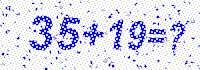

This is grayscale image:


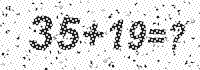

This is processed image after gaussian filter:


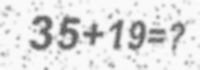

This is processed image after binarization and directional erode:


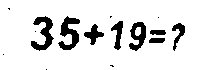

This is processed image after median filter:


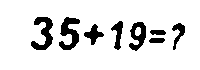

The points of boudary as follows :[[28.0, 12.0], [189.0, 12.0], [189.0, 54.0], [28.0, 54.0]]


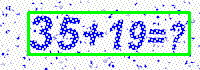

Finally,the recognized text is: 35+19=?
And the confidence level is: 0.9667648673057556


In [27]:
# 该模块随机选择一个数据集图像进行处理
# This module is to randomly select a dataset image for processing
folder_path = '/content/drive/MyDrive/Dataset/math_dataset'

files = os.listdir(folder_path)
random_file = random.choice(files)
full_file_path = os.path.join(folder_path, random_file)

# 图像预处理 Pre-processing
img = cv2.imread(full_file_path)
print(f'This is original image:')
cv2_imshow(img)

# 转为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f'This is grayscale image:')
cv2_imshow(gray)

# 高斯滤波
# Gaussian filter
gaussian = cv2.GaussianBlur(gray, (7,7), 0)
print(f'This is processed image after gaussian filter:')
cv2_imshow(gaussian)

# 二值化和定向侵蚀
# binarization and directional erode
erode = erode_black(gaussian)
print(f'This is processed image after binarization and directional erode:')
cv2_imshow(erode)

# 中值滤波处理比较小的噪声（小黑点）
# Using median filter to deal with the smaller black points.
median = cv2.medianBlur(erode, 3)
print(f'This is processed image after median filter:')
cv2_imshow(median)

# 使用PaddleOCR
# Using PaddleOCR.
ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, det=True, rec=True)
result = ocr.ocr(median, cls=True)
# [[[[[16.0, 8.0], [181.0, 17.0], [179.0, 56.0], [14.0, 48.0]], ('60-1=?', 0.9548397660255432)]]]


# 获取边界框用于绘制
# Getting the numeric data of boundary of the text.
boundary = result[0][0][0]
print(f'The points of boudary as follows :{boundary}')
left_top = tuple(map(int, boundary[0]))
right_bottom = tuple(map(int, boundary[2]))
# 绘制文本框
# Drawing boundary of the text.
marked_img = cv2.rectangle(img, left_top, right_bottom, (0, 255, 0), 2)
cv2_imshow(marked_img)


# 获取文本和概率
# Getting the text and possibility.
print(f'Finally,the recognized text is: {result[0][0][1][0]}')
print(f'And the confidence level is: {result[0][0][1][1]}')
